# Example: Let's build an Observable Markov Model of a Stock Returns
This example will familiarize students with constructing an Observable Markov Model of the excess return of a ticker `XYZ` where we define the excess growth as:
$$
\begin{equation*}
\mu_{ij} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{i,j}}{S_{i,j-1}}\right) - \bar{r}_{f}
\end{equation*}
$$
where $\mu_{ij}$ denotes the excess growth rate of equity $i$ at time $j$, $\Delta{t}$ denotes the time between $j-1\rightarrow{j}$ (units: years), $S_{i,\star}$ denotes the share price of equity $i$ at time $\star$, and $\bar{r}_{f}$ denotes the annualized risk free rate.

## Learning objectives
Describe the day-to-day variation of the excess return using a fully observable Markov model described by the tuple $\mathcal{M} = (\mathcal{S},\mathcal{O},\mathbf{P},\mathbf{E})$; $\mathcal{S}$ is the set of hidden states, $\mathcal{O}$ is the set of observable states, $\mathbf{P}$ is the transition matrix and $\mathbf{E}$ is the emission matrix. Because we are fully observable, the emission matrix $\mathbf{E} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix.

* `Task 1`: Construct the states $\mathcal{S}$, the emission matrix $\mathbf{E}$ and transition matrix $\hat{\mathbf{T}}$
    * `TODO`: Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
* `Task 2`: Simulate the Observable Markov Model (OMM) for an average trading year
    * `TODO`: Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
    * `TODO`: Implement the `MARKOV-SIMULATION` pseudo code from the lecture to generate hypothetical return sequences

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-1/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-1`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-1/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `03-13-2024`, along with data for a few exchange-traded funds and volatility products during that time. In this block of code, we:
* Load and clean the historical data; store the cleaned data in the `dataset` variable.
* We then calculate the expected excess return $\mathbb{E}(R_{i})$ for each `ticker` in `dataset`. You select a firm by changing the value in the `ticker` variable. We store the computed excess return for the `ticker` in the `Rᵢ` variable.

In [79]:
# initialize -
dataset = Dict{String,DataFrame}();
risk_free_rate = 0.05;
ticker = "JNJ"

# load the price dataset full dataset, remove firms with missing data -
original_dataset = MyPortfolioDataSet() |> x->x["dataset"];
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
my_list_of_tickers = keys(dataset) |> collect |> x->sort(x);

# compute the excess return for all tickers -
all_firms_excess_return_matrix = log_growth_matrix(dataset, my_list_of_tickers, 
    Δt = (1.0/252.0), risk_free_rate = risk_free_rate) 

# What is the return -
Rᵢ = findfirst(x->x==ticker, my_list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i];

## Task 1: Construct the states $\mathcal{S}$, the emission matrix $\mathbf{E}$ and transition matrix $\hat{\mathbf{T}}$
First, consider the states $\mathcal{S}$. Suppose we put a label (and number) the excess return values, ranging from `super bad = 1,` $\dots$,` unchanged,` $\dots$,` super good = N,` where if $R\ll{0}$, then we are in the `super bad = 1,` state or $R\gg{0}$ we are in the `super good = N` state (or we are someplace in between). 
* __Idea__: Use the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) computed from the observed return series $R_{i,1}, \dots, R_{i,n}$ to partition the actual (historical) excess returns into one of a fixed number of categories. Once we have the categories, compute the probability that category $i$ on day $k$ is followed by category $j$ on day $k+1$. These values are entries in the state transition matrix $\hat{\mathbf{T}}$.
* To start, specify a value for the  `number_of_states` variable, where the `number_of_states` controls how many categories we are using when splitting up the excess return time series

In [7]:
number_of_states = 100; # TODO: specify a value here
states = range(1,stop=number_of_states) |> collect;

Next, set up the emissions matrix $\mathbf{E}$. For this example, because the states are __fully observable__, i.e., we can see the states directly,  the emission matrix $\mathbf{E}$ is the identity matrix $\mathbf{I}$:

In [9]:
E = diagm(ones(number_of_states));

### TODO: Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
To estimate the transition matrix $\hat{\mathbf{T}}$, we'll estimate the transition probabilities from the excess return data calculated in the `Prerequisites` section and saved in the `Rᵢ` variable:
* Split the data into two blocks: the first (which we'll call the `in_sample_dataset`) will be used to estimate the elements of the matrix $\hat{\mathbf{T}}$, while the second (which we'll call `out_of_sample_dataset`) will be used for testing purposes (later). The fraction of data partitioned into the training dataset is controlled by the `split_fraction` variable.

Set a value for the `split_fraction` variable:

In [11]:
split_fraction = 0.90; # TODO: specify a value here
insample_end_index = round(split_fraction*length(Rᵢ), digits=0) |> Int
in_sample_dataset = Rᵢ[1:insample_end_index]
out_of_sample_dataset = Rᵢ[(insample_end_index+1):end];

Next, we need to model the return data distribution to compute the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function). The excess return distribution is a random variable that follows some [probability distribution function](https://en.wikipedia.org/wiki/Probability_distribution). We don't know what that distribution function is, but for now, we assume the excess returns follow a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)
* We use the [fit_mle function](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl) to fit a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) to our our data. We fit the distribution to the full dataset `Rₘ` and save the distribution in the `d` variable.

In [13]:
d = fit_mle(Laplace, Rᵢ); # use the *full* data set to establish the cutoff's

Next, we generate the percentile cutoffs that we use to establish the bounds that correspond to each category of return, i.e., `super bad` or `super good`, etc.

In [15]:
percentage_cutoff = range(0.0,stop=1.0,length=(number_of_states+1)) |> collect;

Now that we have the cutoffs, compute the lower and upper bound for each potentiual category. To do this, we'll use the [quantile function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). For a given `0 ≤ q ≤ 1`, `quantile(d, q)` is the smallest value `x` 
for which `cdf(d, x) ≥ q`.

In [17]:
bounds = Array{Float64,2}(undef, number_of_states,2)
for s ∈ states
    bounds[s,1] = quantile(d,percentage_cutoff[s])
    bounds[s,2] = quantile(d,percentage_cutoff[s+1])
end
bounds

100×2 Matrix{Float64}:
 -Inf       -7.38453
  -7.38453  -6.06611
  -6.06611  -5.29489
  -5.29489  -4.7477
  -4.7477   -4.32327
  -4.32327  -3.97648
  -3.97648  -3.68327
  -3.68327  -3.42929
  -3.42929  -3.20526
  -3.20526  -3.00485
  -3.00485  -2.82357
  -2.82357  -2.65807
  -2.65807  -2.50582
   ⋮        
   2.77088   2.93638
   2.93638   3.11767
   3.11767   3.31807
   3.31807   3.5421
   3.5421    3.79609
   3.79609   4.08929
   4.08929   4.43608
   4.43608   4.86051
   4.86051   5.4077
   5.4077    6.17893
   6.17893   7.49734
   7.49734  Inf

Now that we have the category bounds, let's take the excess return data and determine which state an excess return observation corresponds to. For each sample in the `in_sample_dataset`:
* Classify the sample value into one of the possible categories. Let `state = 1` equal the worst return, and `state = number_of_states` equal the best return. Save these results in the `encoded_in_sample` array:

In [19]:
encoded_in_sample = Array{Int64,1}();
for i ∈ eachindex(in_sample_dataset)
    value = in_sample_dataset[i];

    class_index = 1;
    for s ∈ states
        if (bounds[s,1] ≤ value && value < bounds[s,2])
            class_index = s;
            break;
        end
    end
    push!(encoded_in_sample, class_index);
end
encoded_in_sample;

In the matrix $\mathbf{T}$ compute the `counts` for transition from state `i` to state `j`:

In [21]:
T = zeros(number_of_states, number_of_states)
for i ∈ 2:insample_end_index
    start_index = encoded_in_sample[i-1];
    stop_index = encoded_in_sample[i];
    T[start_index,stop_index] += 1;
end
T

100×100 Matrix{Float64}:
 4.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  1.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0

From the `counts` matrix $\mathbf{T}$, compute the transtion probability matrix $\hat{\mathbf{T}}$:

In [23]:
T̂ = zeros(number_of_states, number_of_states)
for row ∈ states
    Z = sum(T[row,:]);
    for col ∈ states
        T̂[row,col] = (1/Z)*T[row,col]
    end
end
T̂

100×100 Matrix{Float64}:
 0.222222   0.0        0.0        …  0.0        0.0555556  0.0555556
 0.0        0.0        0.0           0.0        0.0        0.111111
 0.0        0.0        0.0           0.0        0.0909091  0.0
 0.0714286  0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0909091
 0.0        0.0        0.0        …  0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0625
 0.0        0.0        0.0           0.0        0.0666667  0.0
 0.0666667  0.0        0.0           0.0666667  0.0        0.0
 0.0        0.0        0.0        …  0.0        0.0        0.0588235
 0.0        0.0        0.0555556     0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 ⋮                                ⋱                        
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0   

## Task 2: Simulate the Observable Markov Model (OMM)
To do the simulation, we first build a `MyObservableMarkovModel` instance which holds the data for our Markov model. We use a `build(...)` function which takes information about the `states`, the estimated transition matrix $\hat{\mathbf{T}}$, and the emission matrix $\mathbf{E}$ and returns a `MyObservableMarkovModel` instance, which we save in the `model` variable.

In [25]:
model = build(MyObservableMarkovModel, (
    states = states,
    T = T̂, 
    E = E
));

#### Check: What is in `model`
What data is contained in the `model` instance (this is defined in the `Types.jl` file).

In [27]:
model.transition

Dict{Int64, Categorical{P} where P<:Real} with 100 entries:
  5  => Categorical{Float64, Vector{Float64}}(…
  56 => Categorical{Float64, Vector{Float64}}(…
  35 => Categorical{Float64, Vector{Float64}}(…
  55 => Categorical{Float64, Vector{Float64}}(…
  60 => Categorical{Float64, Vector{Float64}}(…
  30 => Categorical{Float64, Vector{Float64}}(…
  32 => Categorical{Float64, Vector{Float64}}(…
  6  => Categorical{Float64, Vector{Float64}}(…
  67 => Categorical{Float64, Vector{Float64}}(…
  45 => Categorical{Float64, Vector{Float64}}(…
  73 => Categorical{Float64, Vector{Float64}}(…
  64 => Categorical{Float64, Vector{Float64}}(…
  90 => Categorical{Float64, Vector{Float64}}(…
  4  => Categorical{Float64, Vector{Float64}}(…
  13 => Categorical{Float64, Vector{Float64}}(…
  54 => Categorical{Float64, Vector{Float64}}(…
  63 => Categorical{Float64, Vector{Float64}}(…
  86 => Categorical{Float64, Vector{Float64}}(…
  91 => Categorical{Float64, Vector{Float64}}(…
  62 => Categorical{Float64,

### TODO: Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
Generate the stationary distribution for the estimated transition matrix $\hat{\mathbf{T}}$ and use it to construct a [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) representing the stationary distrubution, save the [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) in the `π̄`-variable:

In [29]:
π̄ = (T̂^100) |> tmp -> Categorical(tmp[1,:]); # TODO: compute the stationary distribution (approx value is ok)

### TODO: Implement the `MARKOV-SIMULATION` pseudo code from the lecture to generate hypothetical return sequences
*Generate 'number_of_paths' example sequences, each containing 'number_of_steps' days. These variables determine the length and number of our hypothetical return sequences. Assume each path starts from a draw from the stationary distribution `π̄.`
* Save the simulated return sequences in the `archive::Array{Int64,2}(undef, number_of_steps, number_of_paths)` array, where the `row` index corresponds to a path, and the `col` index corresponds to a day.
* We have implemented some shortcut logic to speed up the implementation. To evaluate the Markov model for a `number_of_steps,` issue the command `model(start_state, number_of_steps).` This will compute a chain with `number_of_steps` entries starting as `start_state` and return the simulated sequence as an `array.` 

In [31]:
number_of_paths = 100;
number_of_steps = insample_end_index; # average number of trading days per year
encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    start_state = rand(π̄);
    tmp = model(start_state, number_of_steps)
    for j ∈ 1:number_of_steps
        encoded_archive[j,i] = tmp[j]
    end
end
encoded_archive

1401×100 Matrix{Int64}:
 30  36  20   3  78  20  84   18  44  …   33  84  33  26   41   83  42   9
 63  78  17  72  89  71  80   36  82      48  69  76  27   87   89  27  99
 14   6  74  41  94   1  76   78  35      47  95  18  34   18   87  79  69
 28  46  19  64  35  44  35   94  87      85  90  18  79   66   90  66  64
 25  67  68  62  10  30  87   10  44      34  65  18  90   74   35  62  35
 49  67  26  26  75  95  63   71  60  …    6  94  61  58   19    1  12  66
 33  39  92  70  54  86  47   28  26      74  21  37  65   92   63  44  44
 76  28  44  46  91  10  28   33   2       3  83  31  28    8   65  60  60
 18  63  39  25  68  75   3   94  95      20  69  88   5  100    9  60  54
 26  14  37  37   7  78  35   27  16      96  66  95  26   51   58  95   1
 34  29  19  31  82  44  13   79  37  …   45  49  50  27   70   59  51   1
 94  81  12   6  58  30  23   24  38      95  43  33  84    3   24  94  99
 53  25  23  93  29  63  40   66  86      13  90  59  65   35   66  97  69
 

In [32]:
actual_sample_bounds = copy(bounds);
actual_sample_bounds[1,1] = minimum(in_sample_dataset);
actual_sample_bounds[end,2] = maximum(in_sample_dataset)
actual_sample_bounds

100×2 Matrix{Float64}:
 -23.1459   -7.38453
  -7.38453  -6.06611
  -6.06611  -5.29489
  -5.29489  -4.7477
  -4.7477   -4.32327
  -4.32327  -3.97648
  -3.97648  -3.68327
  -3.68327  -3.42929
  -3.42929  -3.20526
  -3.20526  -3.00485
  -3.00485  -2.82357
  -2.82357  -2.65807
  -2.65807  -2.50582
   ⋮        
   2.77088   2.93638
   2.93638   3.11767
   3.11767   3.31807
   3.31807   3.5421
   3.5421    3.79609
   3.79609   4.08929
   4.08929   4.43608
   4.43608   4.86051
   4.86051   5.4077
   5.4077    6.17893
   6.17893   7.49734
   7.49734  15.8656

### Decode operation
To turn the state $s\in\mathcal{S}$ back into an excess return value, we need to __decode__ the state. To do this, let's construct a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) describing the observed return values associated with each state in the `encoded_in_sample` dataset.
* We collect the observed excess return samples associated with a particular state $s$, store them in a `tmp` array, and use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to estimate a [Normal distribution exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal)

In [65]:
decode_distribution_model = Dict{Int,Normal}()
for s ∈ states

    # what indexes correspond to state s
    index_collection_state_s = findall(x-> x == s, encoded_in_sample);
    tmp = Array{Float64,1}();
    for i ∈ index_collection_state_s
        decoded_value = Rᵢ[i];
        push!(tmp, decoded_value);
    end
    decode_distribution_model[s] = fit_mle(Normal,tmp);
end
decode_distribution_model;

Then, generate a random value for the excess return by sampling the appropriate [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). We develop `number_of_paths` trajectories, each containing `number_of_steps` values. We store these values in the `decoded_archive` variable:

In [67]:
decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    for j ∈ 1:number_of_steps
        
        s = encoded_archive[j,i];
        decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
    end
end
decoded_archive

1401×100 Matrix{Float64}:
 -0.932977     -0.606536    -1.73517    …    2.06188   -0.308402   -3.28425
  0.586854      1.54298     -2.13203         2.90289   -1.14372     7.16962
 -2.46873      -4.05598      1.26793         2.49661    1.64018     0.939667
 -1.08405      -0.101844    -1.87476         2.98444    0.737751    0.63993
 -1.30836       0.81974      0.873797       -0.632643   0.551935   -0.645754
 -0.00817374    0.806869    -1.21453    …  -14.3021    -2.70355     0.739585
 -0.776402     -0.455247     3.5135          0.578057  -0.184465   -0.235815
  1.41653      -1.10313     -0.23094         0.714016   0.454699    0.455171
 -1.97252       0.58541     -0.435732       -3.26184    0.461439    0.207844
 -1.19525      -2.43979     -0.541946        0.371977   4.03432    -9.94411
 -0.717064     -1.01922     -1.87975    …    0.390308   0.0664655  -8.9287
  3.93709       1.79706     -2.78228        -1.35473    3.9024      7.25248
  0.155204     -1.30148     -1.45896         0.757707   5

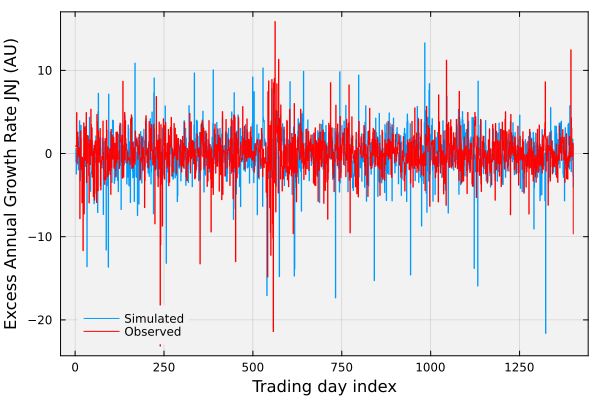

In [69]:
let
    plot(decoded_archive[:,1], linetype=:steppost, label="Simulated", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(in_sample_dataset, linetype=:steppost, c=:red, label="Observed")
    xlabel!("Trading day index", fintsize=18)
    ylabel!("Excess Annual Growth Rate $(ticker) (AU)", fontsize=18)
end

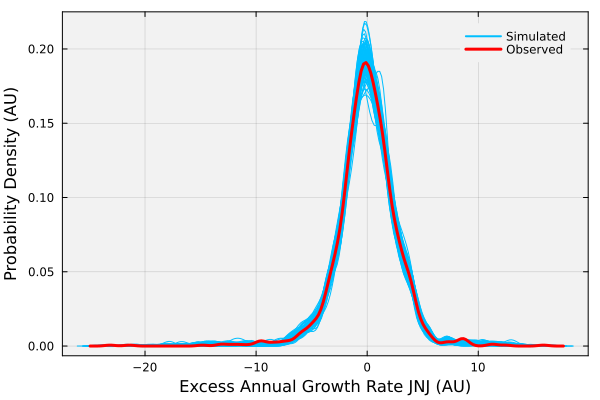

In [71]:
let
    q = plot();
    density!(decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(ticker) (AU)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Are the predicted and observed return distributions the same? 
If our Markov model is correct, then the observed excess return distribution and the excess return distribution calculated by our model should be the same. To check this hypothesis, let's use the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test).
* `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the alternative hypothesis that they come from different distributions.

In [73]:
ApproximateTwoSampleKSTest(in_sample_dataset,decoded_archive[:,10])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0342612

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.3834

Details:
    number of observations:   [1401,1401]
    KS-statistic:              0.9067909391257254


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.